## Programming Exercise 4 - Neural Networks Learning

In [1]:
# %load ../../../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# load MATLAB files
from scipy.io import loadmat

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_seq_items', None)
 
#%config InlineBackend.figure_formats = {'pdf',}
#%matplotlib inline

import seaborn as sns
sns.set_context('notebook')
sns.set_style('darkgrid')

#### Load MATLAB datafiles

In [2]:
data = loadmat('data/ex4data1.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [3]:
y = data['y']
# Add intercept
X = np.c_[np.ones((data['X'].shape[0],1)), data['X']]

print('X:',X.shape, '(with intercept)')
print('y:',y.shape)

X: (5000, 401) (with intercept)
y: (5000, 1)


In [4]:
weights = loadmat('data/ex3weights.mat')
weights.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Theta1', 'Theta2'])

In [6]:
theta1, theta2 = weights['Theta1'], weights['Theta2']
print('theta1 :', theta1.shape)
print('theta2 :', theta2.shape)
params = np.r_[theta1.ravel(), theta2.ravel()]
print('params :', params.shape)

theta1 : (25, 401)
theta2 : (10, 26)
params : (10285,)


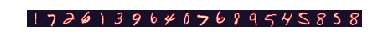

In [7]:
sample = np.random.choice(X.shape[0], 20)
plt.imshow(X[sample,1:].reshape(-1,20).T)
plt.axis('off');

#### Neural Network
Input layer size = 400 (20x20 pixels) <br>
Hidden layer size = 25 <br>
Number of labels = 10

### Neural Networks - Feed Forward and Cost Function

In [8]:
def sigmoid(z):
    return(1 / (1 + np.exp(-z)))

#### Sigmoid gradient
#### $$ g'(z) = g(z)(1 - g(z))$$
where $$ g(z) = \frac{1}{1+e^{-z}}$$

In [9]:
def sigmoidGradient(z):
    return(sigmoid(z)*(1-sigmoid(z)))

### Feedforward

#### Cost Function 
#### $$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}\big[-y^{(i)}_{k}\, log\,(( h_\theta\,(x^{(i)}))_k)-(1-y^{(i)}_k)\,log\,(1-h_\theta(x^{(i)}))_k)\big]$$

#### Regularized Cost Function (with theta_1 and theta_2 in this example)
#### $$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}\bigg[-y^{(i)}_{k}\, log\,(( h_\theta\,(x^{(i)}))_k)-(1-y^{(i)}_k)\,log\,(1-h_\theta(x^{(i)}))_k)\bigg] + \frac{\lambda}{2m}\bigg[\sum_{j=1}^{25}\sum_{k=1}^{400}(\Theta_{j,k}^{(1)})^2+\sum_{j=1}^{10}\sum_{k=1}^{25}(\Theta_{j,k}^{(2)})^2\bigg]$$

### Backpropagation
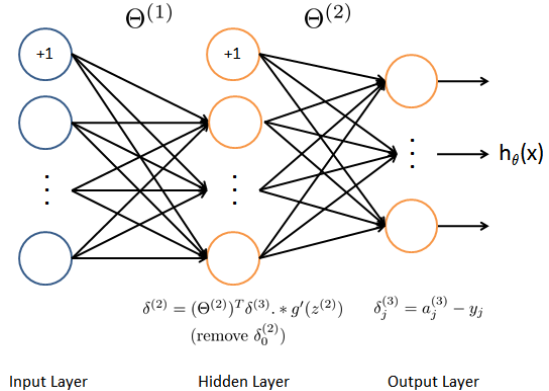


In [10]:
def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, features, classes, reg):
    
    # When comparing to Octave code note that Python uses zero-indexed arrays.
    # But because Numpy indexing does not include the right side, the code is the same anyway.
    theta1 = nn_params[0:(hidden_layer_size*(input_layer_size+1))].reshape(hidden_layer_size,(input_layer_size+1))
    theta2 = nn_params[(hidden_layer_size*(input_layer_size+1)):].reshape(num_labels,(hidden_layer_size+1))

    m = features.shape[0]
    y_matrix = pd.get_dummies(classes.ravel()).as_matrix() # 5000x10
    
    # Feedforward
    # Cost
    a1 = features # 5000x401
        
    z2 = theta1.dot(a1.T) # 25x401 * 401x5000 = 25x5000 
    a2 = np.c_[np.ones((features.shape[0],1)),sigmoid(z2.T)] # 5000x26 
    
    z3 = theta2.dot(a2.T) # 10x26 * 26x5000 = 10x5000 
    a3 = sigmoid(z3) # 10x5000
    
    J = -1*(1/m)*np.sum((np.log(a3.T)*(y_matrix)+np.log(1-a3).T*(1-y_matrix))) + \
        (reg/(2*m))*(np.sum(np.square(theta1[:,1:])) + np.sum(np.square(theta2[:,1:])))

    # Back propogation
    # Gradients
    d3 = a3.T - y_matrix # 5000x10
    d2 = theta2[:,1:].T.dot(d3.T)*sigmoidGradient(z2) # 25x10 *10x5000 * 25x5000 = 25x5000
    
    delta1 = d2.dot(a1) # 25x5000 * 5000x401 = 25x401
    delta2 = d3.T.dot(a2) # 10x5000 *5000x26 = 10x26
    
    theta1_ = np.c_[np.ones((theta1.shape[0],1)),theta1[:,1:]]
    theta2_ = np.c_[np.ones((theta2.shape[0],1)),theta2[:,1:]]
    
    theta1_grad = delta1/m + (theta1_*reg)/m
    theta2_grad = delta2/m + (theta2_*reg)/m
    
    return(J, theta1_grad, theta2_grad)

In [11]:
# Regularization parameter = 0
nnCostFunction(params, 400, 25, 10, X, y, 0)[0]

/home/annguyen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


0.28762916516131887

In [12]:
# Regularization parameter = 1
nnCostFunction(params, 400, 25, 10, X, y, 1)[0]

/home/annguyen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


0.3837698590909236

In [13]:
[sigmoidGradient(z) for z in [-1, -0.5, 0, 0.5, 1]]

[0.19661193324148185,
 0.2350037122015945,
 0.25,
 0.2350037122015945,
 0.19661193324148185]